<a href="https://colab.research.google.com/github/kyle-gao/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis/blob/main/SWL_TextureSynthesis_New_tag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some references 

https://www.tensorflow.org/tutorials/generative/style_transfer

https://github.com/tchambon/A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis

B

For output image C, stlye image A, content Image B,

the overall loss function is $C = aL_{content}(A,C) + bL_{style}(B,C)$

Where $L_{style}$ is defined as the MSE loss between the gram matrices at specific layers for the two images. Can use multiple style layers.$

$L_{content}$ is defined as the MSE loss between the pixels of the two images.


The authors suggest replacing the gram style loss with a sliced Wassestein loss.


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import shutil

In [ ]:
SIZE = 256
INPUT_FILE = "./input.jpg"
OUTPUT_FILE = "./output.jpg"
NB_ITER = 20

In [ ]:
!gdown --id 1Bhdy0qXvhuCe6gn1jy4fnYFFDetUnFlv
!gdown --id 1rAtEF312C4_Z8AEzTOthkkdHT4Esc4sS
!gdown --id 1wvXk5sIDsik240vPKgiWhHKJP2eZwDw4
!gdown --id 1v5mMu41e9KoCkrPxv5OAh6J3Kc5_WH5k

Downloading...
From: https://drive.google.com/uc?id=1Bhdy0qXvhuCe6gn1jy4fnYFFDetUnFlv
To: /content/input.jpg
100% 16.8k/16.8k [00:00<00:00, 6.60MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rAtEF312C4_Z8AEzTOthkkdHT4Esc4sS
To: /content/vgg_customized.h5
100% 80.2M/80.2M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wvXk5sIDsik240vPKgiWhHKJP2eZwDw4
To: /content/texturegen.py
100% 6.26k/6.26k [00:00<00:00, 17.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v5mMu41e9KoCkrPxv5OAh6J3Kc5_WH5k
To: /content/SpatialTags.zip
100% 591k/591k [00:00<00:00, 39.4MB/s]


In [ ]:
shutil.unpack_archive("/content/SpatialTags.zip")

In [ ]:
"""The loss function is implemented in class Slicing(...) and is used by ExtractorVggModel which directly returns loss """

def decode_image(path, size=SIZE):
    """ Load and resize the input texture """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    max_size = img.shape[0]
    if max_size > img.shape[1]: max_size = img.shape[1]

    img = tf.image.resize_with_crop_or_pad(img, max_size, max_size)
    img = tf.image.resize(img, [size, size]) 
    img = tf.image.convert_image_dtype(img, tf.float32) / 255

    return img[None]


class Slicing(tf.keras.layers.Layer):
    """ Slicing layer: computes projections and returns sorted vector """
    def __init__(self, num_slices):
        super().__init__()
        # Number of directions
        self.num_slices = num_slices
        self.flatten_layer = tf.keras.layers.Flatten()

    def update_slices(self):
        """ Update random directions """
        # Generate random directions
        self.directions = tf.random.normal(shape=(self.num_slices, self.dim_slices))
        # Normalize directions
        norm = tf.reshape( K.sqrt( K.sum( K.square(self.directions), axis=-1 )), (self.num_slices, 1))
        self.directions = tf.divide(self.directions, norm)

    def build(self, input_shape):
        self.dim_slices = input_shape[-1]
        self.update_slices()

    def call(self, input):
        """ Implementation of figure 2 """
        tensor = tf.reshape(input, (tf.shape(input)[0], -1, tf.shape(input)[-1]))
        # Project each pixel feature onto directions (batch dot product)
        sliced = self.directions @ tf.transpose(tensor, perm=[0,2,1])
        # Sort projections for each direction
        sliced = tf.sort(sliced)
        
        return self.flatten_layer(sliced)

def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # A customized vgg is used as explained in the supplementals.
    vgg = keras.models.load_model('vgg_customized.h5')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)

    return model

class ExtractorVggModel(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers):
        super().__init__()
        self.vgg =  vgg_layers(layers)
        self.vgg.trainable = False    

        self.slicing_losses = [Slicing(num_slices=l.shape[-1]) for i, l in enumerate(self.vgg.outputs)]

    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs):
        outputs = self.vgg(inputs)
        outputs = [self.slicing_losses[i](output)
                        for i, output in enumerate(outputs)]

        return outputs

    

def loss_and_grad(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    extractor = args['extractor']
    targets = args['targets']

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        outputs = extractor(image_tf)
        #L2 between the sorted slices (generated image vs target texture)
        losses =[tf.reduce_mean((output-targets[i])**2) 
                           for i, output in enumerate(outputs)]
        loss = tf.add_n(losses)
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def slice_loss(image, target,extractor):
    image_feats = extractor(image)
    target_feats = extractor(target)
    losses =[tf.reduce_mean((output-target_feats[i])**2) 
                           for i, output in enumerate(image_feats)]
    loss = tf.add_n(losses)
    return loss

def gram_loss(image,target,feature_layers):
  #extractor(image) is list of (1,X,Y,C)
  gram_image = [gram_matrix(feature) for feature in feature_layers(image)]
  gram_target = [gram_matrix(feature) for feature in feature_layers(target)]
  #sum of MSE gram matrix difference across layers
  style_loss = tf.add_n([tf.reduce_mean((gram_image[idx]-gram_target[idx])**2) for idx,_ in enumerate(gram_image)])

  return style_loss




def fit_slice(nb_iter, texture, extractor, feature_layers = None):
    targets = extractor(texture) #this is passed to loss_and_grad to compute loss
  
    # Image initialization  
    image = np.zeros((1,SIZE,SIZE,3))
    image = image + tf.reduce_mean(texture, axis=(1, 2))[None, None]
    image = image + (tf.random.normal((1, SIZE,SIZE, 3))*1e-2)
    
    losses_gram = []
    losses_slice = []
        
    
    for i in range(nb_iter):
        arg_opt = {'extractor': extractor, 'targets':targets}

        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')
        
     
        # Change random directions (optional)
        extractor.update_slices()
        targets = extractor(texture)

        #export image at the current iteration
        image = np.reshape(image, (1,SIZE, SIZE, 3))
        
        #plt.imsave(f'output-iter{i+1}.jpg', image)


        loss1 = gram_loss(image, texture, feature_layers)
        loss2 = slice_loss(image, texture, extractor)
        losses_gram.append(loss1)
        losses_slice.append(loss2)
            
    return image,losses_gram,losses_slice

trying to get gram matrix with bfgs_b

In [ ]:
def loss_and_grad_gram(image,feature_layers):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')

    gram_target = [gram_matrix(feature) for feature in feature_layers(target)]

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        gram_image = [gram_matrix(feature) for feature in feature_layers(image_tf)]

        

        #L2 between the sorted slices (generated image vs target texture)
        loss = tf.add_n([tf.reduce_mean((gram_image[idx]-gram_target[idx])**2) for idx,_ in enumerate(gram_image)])
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_gram(nb_iter, texture, extractor, feature_layers):
    image = initialize_image(SIZE, texture)

    losses_gram = []
    losses_slice = []

    for i in range(nb_iter):

        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_gram,args=[feature_layers], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')

        #export image at the current iteration
        image = np.reshape(image, (1,SIZE, SIZE, 3)).astype('float32')
        #plt.imsave(f'output-iter{i+1}.jpg', image)

        loss1 = gram_loss(image, texture, feature_layers)
        
        loss2 = slice_loss(image, texture, extractor)
        losses_gram.append(loss1)
        losses_slice.append(loss2)
            
    return image,losses_gram,losses_slice

In [ ]:
def decode_image_with_patch(path, patch_size= 32, target_size = SIZE, pad_type = 'wrap'):
    """ Load and resize the input texture 
    pad type : see np.pad: 'wrap','reflect','symmetric' etc..."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    max_size = img.shape[0]
    if max_size > img.shape[1]: max_size = img.shape[1]
    pad_size = int(np.round((target_size-patch_size)/2))

    img = tf.image.resize_with_crop_or_pad(img, patch_size, patch_size)
    img = np.pad(img,pad_width=((pad_size,pad_size),(pad_size,pad_size),(0,0)), mode=pad_type)
    img = tf.image.resize(img, [target_size, target_size]) 

    img = tf.image.convert_image_dtype(img, tf.float32)/255

    return img[None]

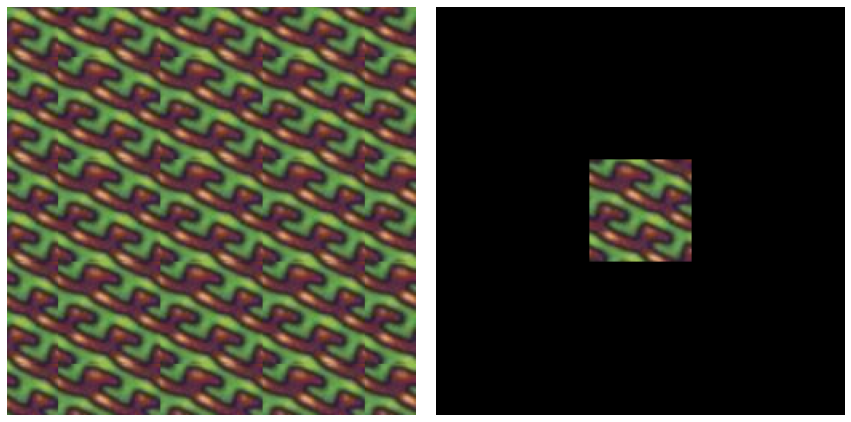

In [ ]:
texture_reference_wrap = decode_image_with_patch("input.jpg", patch_size=64, target_size = SIZE)
texture_reference_zero = decode_image_with_patch("input.jpg", patch_size=64, target_size = SIZE,pad_type='constant')

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(texture_reference_wrap[0,:,:,:])
ax2.imshow(texture_reference_zero[0,:,:,:])
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

In [ ]:
############################ MAIN ############################
# VGG layers used for the loss
layers = ['block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1', 
                'block3_conv2',
                'block3_conv3',
                'block3_conv4',
                'block4_conv1', 
                'block4_conv2',
                'block4_conv3',
                'block4_conv4',
                'block5_conv1',
                'block5_conv2'
               ]


slice_extractor = ExtractorVggModel(layers)

vgg_layers_extractor = vgg_layers(layers)

#took around 6min per iteration on CPU colab instance
#texture_reference = decode_image(INPUT_FILE, size=SIZE)
# export of the resized input: reference to compare against the generated texture

In [ ]:
extractor = vgg_layers(layers)
slice_extractor = ExtractorVggModel(layers)
target = texture_reference_wrap

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def initialize_image(SIZE,texture):
    image = np.zeros((1,SIZE,SIZE,3))
    image = image + tf.reduce_mean(texture, axis=(1, 2))[None, None]
    image = image + (tf.random.normal((1, SIZE,SIZE, 3))*1e-2)
    return image

def gram_loss_1p(image):
  #extractor(image) is list of (1,X,Y,C)
  gram_image = [gram_matrix(feature) for feature in extractor(image)]
  gram_target = [gram_matrix(feature) for feature in extractor(target)]
  #sum of MSE gram matrix difference across layers
  style_loss = tf.add_n([tf.reduce_mean((gram_image[idx]-gram_target[idx])**2) for idx,_ in enumerate(gram_image)])

  return style_loss

def slice_loss_1p(image):
  """ Return loss and grad for a step. Called by lbfgs optimize  """
  slice_image = slice_extractor(image)
  slice_target = slice_extractor(target)
  slice_loss = tf.add_n([tf.reduce_mean((slice_image[idx]-slice_target[idx])**2) for idx,_ in enumerate(slice_image)])
  return slice_loss


In [ ]:
output_image_wrap,out_gram_losses_wrap,out_slice_losses_wrap = fit_slice(NB_ITER, texture_reference_wrap, slice_extractor,vgg_layers_extractor)
output_image_zero,out_gram_losses_zero,out_slice_losses_zero = fit_slice(NB_ITER, texture_reference_zero, slice_extractor,vgg_layers_extractor)

iter 1 loss [0.04217539]
iter 2 loss [0.02871556]
iter 3 loss [0.02462963]
iter 4 loss [0.02247448]
iter 5 loss [0.02069582]
iter 6 loss [0.01907127]
iter 7 loss [0.01814613]
iter 8 loss [0.01723066]
iter 9 loss [0.01698831]
iter 10 loss [0.01620506]
iter 11 loss [0.01570216]
iter 12 loss [0.01522948]
iter 13 loss [0.01498386]
iter 14 loss [0.01442601]
iter 15 loss [0.01440163]
iter 16 loss [0.01425929]
iter 17 loss [0.01380331]
iter 18 loss [0.01365287]
iter 19 loss [0.01339492]
iter 20 loss [0.01324205]
iter 1 loss [0.15785629]
iter 2 loss [0.11741432]
iter 3 loss [0.10298582]
iter 4 loss [0.09005694]
iter 5 loss [0.08108007]
iter 6 loss [0.07841863]
iter 7 loss [0.0757589]
iter 8 loss [0.06893588]
iter 9 loss [0.06604234]
iter 10 loss [0.06473628]
iter 11 loss [0.06336139]
iter 12 loss [0.06265693]
iter 13 loss [0.05906159]
iter 14 loss [0.05471433]
iter 15 loss [0.0530631]
iter 16 loss [0.05261317]
iter 17 loss [0.05221138]
iter 18 loss [0.05100236]
iter 19 loss [0.05172304]
iter 2

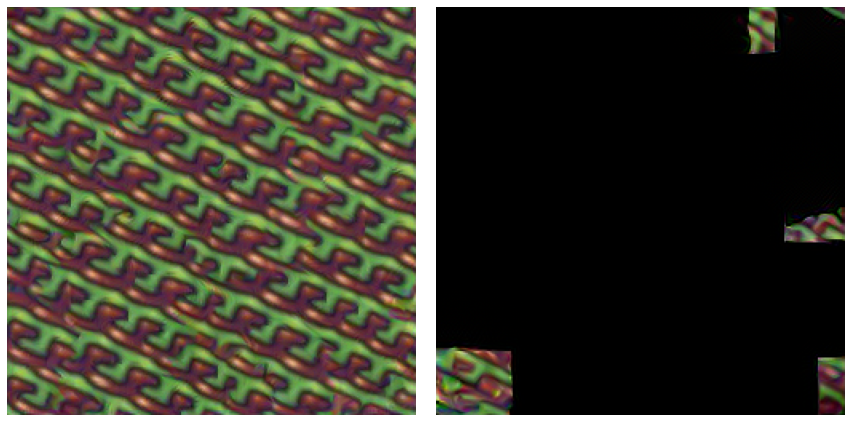

In [ ]:
plt.imsave("Output_wrap_pad.jpg", output_image_wrap)   
plt.imsave("output_zero_pad.jpg", output_image_zero )
fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_image_wrap[0,:,:,:])
ax2.imshow(output_image_zero[0,:,:,:])
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

In [ ]:
vgg_extractor = vgg_layers(layers)
gram_wrap, traingram_wrap_gram,traingram_warp_slice = fit_gram(20,texture_reference_wrap,slice_extractor,vgg_layers_extractor)
gram_zero,traingram_zero_gram,traingram_zero_slice  = fit_gram(20,texture_reference_zero,slice_extractor,vgg_layers_extractor)

iter 1 loss [0.01343771]
iter 2 loss [0.00529781]
iter 3 loss [0.0034436]
iter 4 loss [0.00260366]
iter 5 loss [0.00211462]
iter 6 loss [0.00182632]
iter 7 loss [0.00161276]
iter 8 loss [0.00146012]
iter 9 loss [0.00134868]
iter 10 loss [0.00128089]
iter 11 loss [0.00122253]
iter 12 loss [0.00116965]
iter 13 loss [0.00112722]
iter 14 loss [0.00108591]
iter 15 loss [0.00104918]
iter 16 loss [0.00101503]
iter 17 loss [0.00098766]
iter 18 loss [0.00096175]
iter 19 loss [0.00093699]
iter 20 loss [0.00091461]
iter 1 loss [0.01438055]
iter 2 loss [0.0062331]
iter 3 loss [0.00394889]
iter 4 loss [0.00293619]
iter 5 loss [0.00236893]
iter 6 loss [0.00199926]
iter 7 loss [0.00172554]
iter 8 loss [0.00152855]
iter 9 loss [0.00138433]
iter 10 loss [0.0012865]
iter 11 loss [0.00120702]
iter 12 loss [0.00113947]
iter 13 loss [0.00108545]
iter 14 loss [0.00104349]
iter 15 loss [0.00101006]
iter 16 loss [0.00098018]
iter 17 loss [0.00095487]
iter 18 loss [0.00093296]
iter 19 loss [0.0009129]
iter 20 

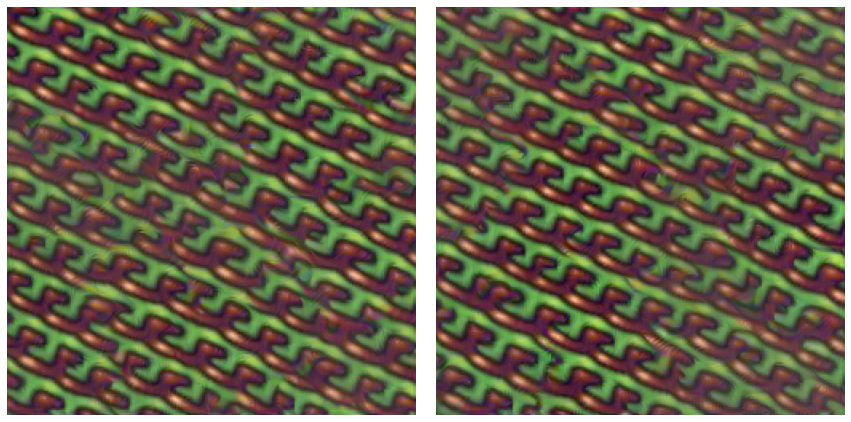

In [ ]:
fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(gram_wrap[0,:,:,:])
ax2.imshow(gram_zero[0,:,:,:])
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

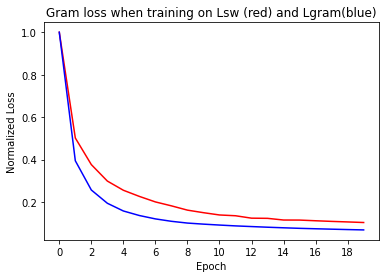

In [ ]:
TS_gram_plot = np.array(out_gram_losses_wrap)
TS_slice_plot = np.array(out_slice_losses_wrap)
TG_slice_plot = np.array(traingram_warp_slice)
TG_gram_plot = np.array(traingram_wrap_gram)

plt.plot(TS_gram_plot/TS_gram_plot[0],'r')
plt.plot(TG_gram_plot/TG_gram_plot[0],'b')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.xticks(np.arange(0,20,2))
plt.title("Gram loss when training on Lsw (red) and Lgram(blue)")
plt.show()


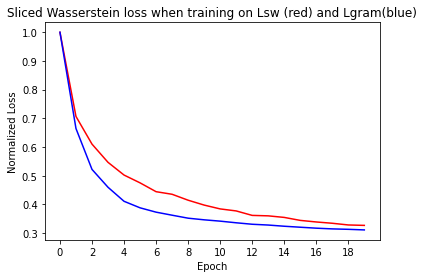

In [ ]:
plt.plot(TS_slice_plot/TS_slice_plot[0],'r')
plt.plot(TG_slice_plot/TG_slice_plot[0],'b')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.xticks(np.arange(0,20,2))
plt.title("Sliced Wasserstein loss when training on Lsw (red) and Lgram(blue)")
plt.show()

#Using Adam optimizer

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)
image = initialize_image(256, texture_reference_wrap)
image_var = tf.Variable(image)

def train_step_gram(image):
  with tf.GradientTape() as tape:
    loss = gram_loss(image)
  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  return loss


def train_step(image,loss_fn):
  with tf.GradientTape() as tape:
    loss = loss_fn(image)
  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  return loss

In [ ]:
image_var = tf.Variable(image)
loss = []
iter = 200
for i in range(iter):
  loss.append(train_step(image_var,slice_loss))

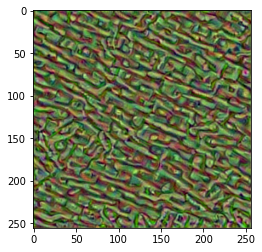

In [ ]:
plt.imshow(image_var[0,:,:,:])

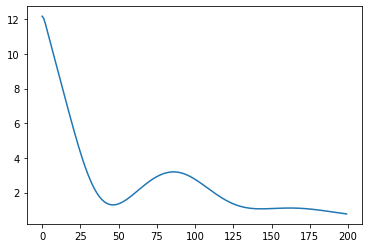

In [ ]:
plt.plot(loss)

In [ ]:
!python texturegen.py --size 128 --iter 5 input.jpg #doesn't workt with different size than 256 ROFl

Launching texture synthesis from input.jpg on size 128 for 5 steps. Output file: output.jpg
2021-10-28 21:41:35.368081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:41:35.402000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:41:35.402539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:41:35.403459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:41:35.403928: 

In [ ]:
def decode_and_crop(path, size=SIZE):
    """ Load and resize the input texture """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    max_size = img.shape[0]
    if max_size > img.shape[1]: max_size = img.shape[1]

    img = tf.image.resize_with_crop_or_pad(img, size, size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img[None]

# Spatial Tags

In [ ]:
import cv2

In [ ]:
def decode_image_spatial_tag(path, size=SIZE,channels=3,method = 'nearest'):
    """ Load and resize the input texture """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.image.resize(img, [size, size], method = method) 
    img = tf.math.round(img)
    img = tf.image.convert_image_dtype(img, tf.float32)/255
    return img[None]

In [ ]:
tag_layers = [
              tf.identity,
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity,
              tf.identity,
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity,
              tf.identity,
              tf.identity,
              tf.keras.layers.MaxPool2D(),
              tf.identity
]

def tag_layers_extractor(layers,tag):
  out = []
  for layer in layers:
    tag = layer(tag)
    out.append(tag)
  return out

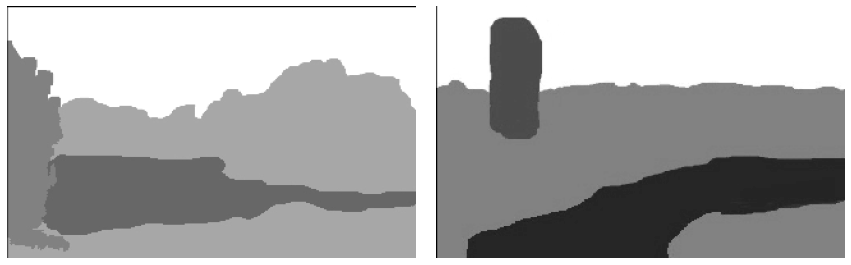

In [ ]:
tag11 = cv2.imread("/content/SpatialTags/Tag1.png",0)
tag22 = cv2.imread("/content/SpatialTags/Tag2.png",0)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(tag11,cmap="gray")
ax2.imshow(tag22,cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)


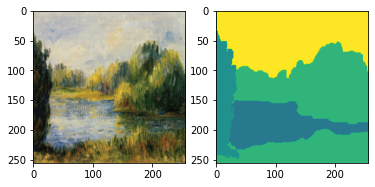

In [ ]:
texture1np = decode_image_spatial_tag("/content/SpatialTags/Image1.png",size=256,method='bilinear').numpy()
tag1np = decode_image_spatial_tag("/content/SpatialTags/Tag1.png",size=256,channels=1,method='nearest').numpy()*255
texture2np = decode_image_spatial_tag("/content/SpatialTags/Image2.png",size=256,method='bilinear').numpy()
tag2np = decode_image_spatial_tag("/content/SpatialTags/Tag2.png",size=256,channels=1,method='nearest').numpy()*255

fig ,(ax1,ax2) = plt.subplots(1, 2)
ax1.imshow(texture1np[0,:,:,:])
ax2.imshow(tag1np[0,:,:,0])

Fixing the stupid tags so there are only 4 colors

In [ ]:
keep_colors1 = colors[np.argsort(-counts)[0:4]]
keep_colors2 = colors2[np.argsort(-counts2)[0:4]]

for idx,_ in np.ndenumerate(tag1np):
  pixel1 = tag1np[idx]
  pixel2 = tag2np[idx]
  closest_color1 = keep_colors1[np.abs(np.array(keep_colors1) - pixel1).argmin()]
  closest_color2 = keep_colors2[np.abs(np.array(keep_colors2) - pixel2).argmin()]
  tag1np[idx] = closest_color1
  tag2np[idx] = closest_color2

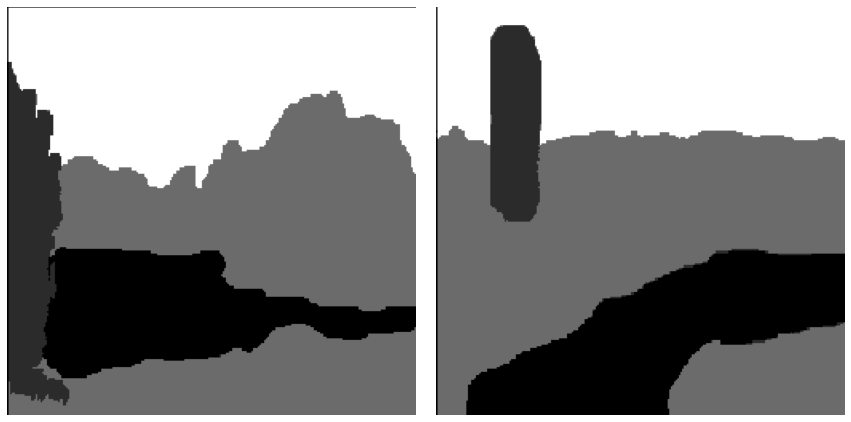

In [ ]:
fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(tag1np[0,:,:,0],cmap="gray")
ax2.imshow(tag2np[0,:,:,0],cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

In [ ]:
tag1np=tag1np
tag2np=tag2np


In [ ]:
tag1 = tf.image.convert_image_dtype(tag1np, tf.float32)
tag2 = tf.image.convert_image_dtype(tag2np, tf.float32)
texture1 = tf.image.convert_image_dtype(texture1np, tf.float32)
np.unique(tag1)

array([16.156864, 20.235294, 26.19608 , 40.      ], dtype=float32)

In [ ]:
tag1np[tag1np==16.156864/40] = 20/2
tag2np[tag2np==16.156864/40] = 20/2
tag1np[tag1np==20.235294/40] = -10/2
tag2np[tag2np==20.235294/40] = -10/2

tag1np[tag1np==26.19608/40] = -20/2
tag2np[tag2np==26.19608/40] = -20/2

tag1np[tag1np==40/40] = 10/2
tag2np[tag2np==40/40] = 10/2

In [ ]:
np.unique(tag1np)

array([-10.,  -5.,   5.,  10.], dtype=float32)

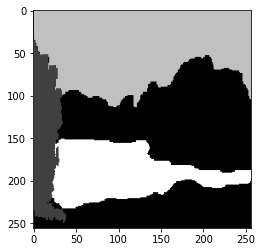

In [ ]:
plt.imshow(tag1np[0,:,:,0],cmap='gray')

In [ ]:

class Slicing_with_tag(tf.keras.layers.Layer):
    """ Slicing layer: computes projections and returns sorted vector """
    def __init__(self, num_slices):
        super().__init__()
        # Number of directions
        self.num_slices = num_slices
        self.flatten_layer = tf.keras.layers.Flatten()

    def update_slices(self):
        """ Update random directions """
        # Generate random directions
        self.directions = tf.random.normal(shape=(self.num_slices, self.dim_slices-1))
        ones = tf.ones((self.num_slices,1))
        self.directions = tf.concat([self.directions,ones],axis=-1)

        # Normalize directions
        norm = tf.reshape( K.sqrt( K.sum( K.square(self.directions), axis=-1 )), (self.num_slices, 1))
        self.directions = tf.divide(self.directions, norm)

    def build(self, input_shape):
        self.dim_slices = input_shape[-1]
        self.update_slices()

    def call(self, input):
        """ Implementation of figure 2 """
        tensor = tf.reshape(input, (tf.shape(input)[0], -1, tf.shape(input)[-1]))
        # Project each pixel feature onto directions (batch dot product)
        sliced = self.directions @ tf.transpose(tensor, perm=[0,2,1])
        # Sort projections for each direction
        sliced = tf.sort(sliced)
        
        return self.flatten_layer(sliced)

class ExtractorVggModelSpatialTags(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers, tag_layers):
        super().__init__()
        self.vgg =  vgg_layers(layers)
        self.vgg.trainable = False
        self.tag_layers = tag_layers    

        self.slicing_losses = [Slicing_with_tag(num_slices=(l.shape[-1])) for i, l in enumerate(self.vgg.outputs)]
    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs, tags):
        outputs = self.vgg(inputs)
        tags_pyramid = tag_layers_extractor(self.tag_layers,tags)

        texture_with_tag = [tf.concat([outputs[idx],tags_pyramid[idx]],axis=-1) for idx,_ in enumerate(outputs)] #concat the spatial tags at the end


        outputs = [self.slicing_losses[i](output) for i, output in enumerate(texture_with_tag)]

        return outputs
def loss_and_grad_tag(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    extractor = args['extractor']
    targets = args['targets']
    image_tag = args['image_tag']

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        outputs = extractor(image_tf,image_tag)
        #L2 between the sorted slices (generated image vs target texture)
        losses =[tf.reduce_mean((output-targets[i])**2) 
                           for i, output in enumerate(outputs)]
        loss = tf.add_n(losses)
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')
    
def fit_slice_spatialtag(nb_iter, texture, texture_tag, image_tag, extractor):
    targets = extractor(texture,texture_tag) #this is passed to loss_and_grad to compute loss
  
    # Image initialization  
    image = np.zeros((1,SIZE,SIZE,3))
    image = image + tf.reduce_mean(texture, axis=(1, 2))[None, None]
    image = image + (tf.random.normal((1, SIZE,SIZE, 3))*1e-2)
    
    #losses_gram = []
    losses_slice = []
        
    
    for i in range(nb_iter):
        arg_opt = {'extractor': extractor, 'targets':targets, 'image_tag':image_tag}

        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_tag, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')
        
     
        # Change random directions (optional)
        extractor.update_slices()
        targets = extractor(texture,texture_tag)

        #export image at the current iteration
        image = np.reshape(image, (1,SIZE, SIZE, 3))
        
        #plt.imsave(f'Spatialtag_iter{i+1}.jpg', image)


        #loss1 = gram_loss(image, texture, feature_layers)
        #loss2 = slice_loss(image, texture, extractor)
        #losses_gram.append(loss1)
        #losses_slice.append(loss2)
        losses_slice.append(loss)
            
    return image,losses_slice



In [ ]:
extractor_tag = ExtractorVggModelSpatialTags(layers,tag_layers)
image, loss_slices = fit_slice_spatialtag(50, texture1, tag1np, tag2np, extractor_tag)

iter 1 loss [0.09422619]
iter 2 loss [0.05239397]
iter 3 loss [0.04438524]
iter 4 loss [0.04118807]
iter 5 loss [0.03901866]
iter 6 loss [0.03827332]
iter 7 loss [0.0370273]
iter 8 loss [0.03588085]
iter 9 loss [0.03595222]
iter 10 loss [0.03492935]
iter 11 loss [0.03485091]
iter 12 loss [0.03406214]
iter 13 loss [0.03401521]
iter 14 loss [0.03403629]
iter 15 loss [0.03275846]
iter 16 loss [0.03297923]
iter 17 loss [0.03220737]
iter 18 loss [0.03239983]
iter 19 loss [0.03261036]
iter 20 loss [0.03199526]
iter 21 loss [0.03185755]
iter 22 loss [0.03154695]
iter 23 loss [0.03083905]
iter 24 loss [0.03104516]
iter 25 loss [0.03067102]
iter 26 loss [0.03096143]
iter 27 loss [0.03120242]
iter 28 loss [0.03031151]
iter 29 loss [0.03043563]
iter 30 loss [0.03067289]
iter 31 loss [0.03073356]
iter 32 loss [0.03039388]
iter 33 loss [0.03048204]
iter 34 loss [0.03069945]
iter 35 loss [0.03036713]
iter 36 loss [0.02980177]
iter 37 loss [0.03045359]
iter 38 loss [0.03005517]
iter 39 loss [0.030126

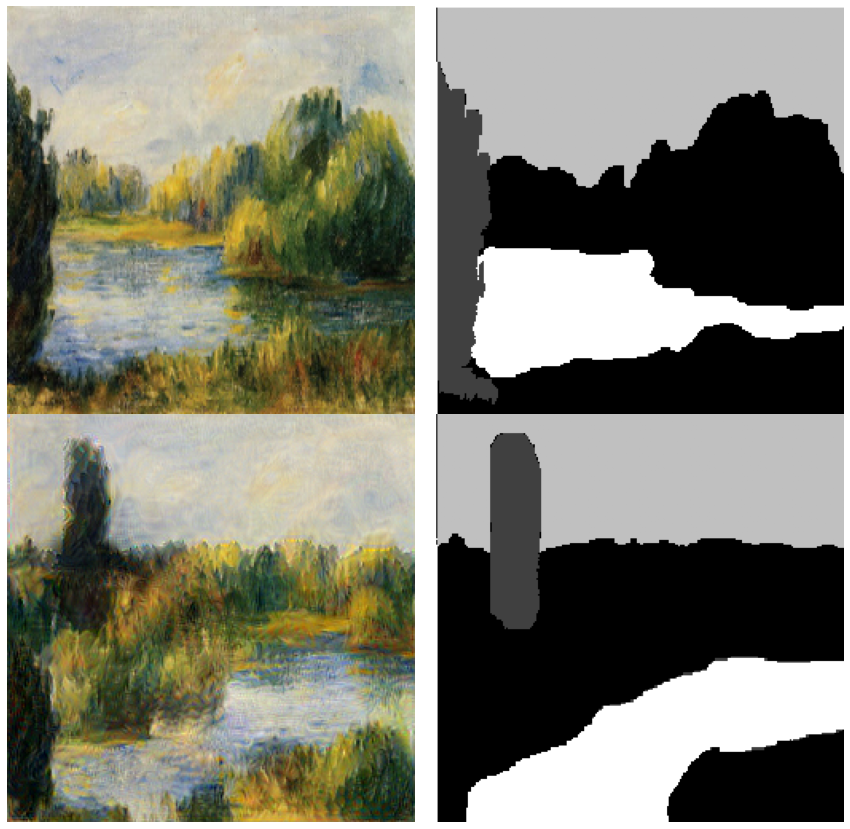

In [ ]:
fig ,axes = plt.subplots(2, 2,figsize=(15,15))
axes[0,0].imshow(texture1np[0,:,:,:])
axes[0,1].imshow(tag1np[0,:,:,0],cmap="gray")
axes[1,0].imshow(image[0,:,:,:])
axes[1,1].imshow(tag2np[0,:,:,0],cmap="gray")

axes[0,0].axis('off')
axes[1,0].axis('off')
axes[0,1].axis('off')
axes[1,1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

Text(0.5, 1.0, 'Spatial tag Lsw')

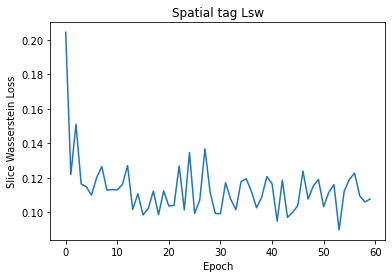

In [ ]:
plt.plot(loss_slices)
plt.xlabel("Epoch")
plt.ylabel("Slice Wasserstein Loss")
plt.title("Spatial tag Lsw")

#Garbage scribbles

In [ ]:
layers_texture = [
                'block3_conv1', 
                'block3_conv2',
                'block3_conv3',
                'block3_conv4',
                'block4_conv1', 
                'block4_conv2',
                'block4_conv3',
                'block4_conv4',
                'block5_conv1',
                'block5_conv2'
               ]

extractor_texture = ExtractorVggModel(layers_texture)

In [ ]:
texture = extractor_texture(texture_image)

NameError: ignored

In [ ]:
vgg.input

NameError: ignored

In [ ]:
vgg = keras.models.load_model('vgg_customized.h5')

In [ ]:
vgg.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'lambda_input')>

In [ ]:
from tensorflow import keras  # or import keras for standalone version
from tensorflow.keras.layers import Input

from tfkerassurgeon.operations import delete_layer, insert_layer


def vgg_layers_custom(layer_names,input_shape=(512, 512, 3) ):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # A customized vgg is used as explained in the supplementals.
    vgg = keras.models.load_model('vgg_customized.h5')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    input = tf.keras.Input(shape=input_shape)

    model = tf.keras.Model([vgg.input], outputs) #if we put input here, the graph disconnects
    model = delete_layer(model,model.layers[0])
    model = insert_layer(model,model.layers[0],input)

    return model

vgg_layers_custom(layers)

AttributeError: ignored

In [ ]:
vgg19 = tf.keras.applications.vgg16.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

553476096/553467096 [==============================] - 7s 0us/step


In [ ]:
def vgg_layers_custom(layer_names,input_shape=(256, 256, 3) ):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # A customized vgg is used as explained in the supplementals.
    vgg = vgg19 = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=input_shape, pooling=None, classes=1000,
    classifier_activation='softmax'
)
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs) #if we put input here, the graph disconnects

    return model

class ExtractorVggModel(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers, input_shape=(256, 256, 3)):
        super().__init__()
        self.vgg =  vgg_layers_custom(layers,input_shape)
        self.vgg.trainable = False    

        self.slicing_losses = [Slicing(num_slices=l.shape[-1]) for i, l in enumerate(self.vgg.outputs)]

    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs):
        outputs = self.vgg(inputs)
        outputs = [self.slicing_losses[i](output)
                        for i, output in enumerate(outputs)]

        return outputs

In [ ]:
layers = ['block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1', 
                'block3_conv2',
                'block3_conv3',
                'block4_conv1', 
                'block4_conv2',
                'block4_conv3',
                'block5_conv1',
                'block5_conv2'
               ]
extractor_small = ExtractorVggModel(layers,(64, 64, 3))
extractor_large = ExtractorVggModel(layers,(512, 512, 3))

In [ ]:
SIZE=512
image = np.zeros((1,SIZE,SIZE,3))
image = image + tf.reduce_mean(texture_image, axis=(1, 2))[None, None]
image = image + (tf.random.normal((1, SIZE,SIZE, 3))*1e-2)

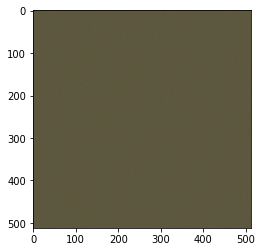

In [ ]:
plt.imshow(image[0,:,:,:])

In [ ]:
def sw_loss(image, target, extractor_image, extractor_target):
  
  image_slice = extractor_image(image)
  target_slice = extractor_target(target)
  losses =[tf.reduce_mean((output-targets[i])**2) for i, output in enumerate(outputs)]

  return loss
  
loss = sw_loss(image,texture_image,vgg_large,vgg_small)

NameError: ignored

In [ ]:
out1 = extractor_small(texture_image)
out2 = extractor_large(image)

In [ ]:
out1 - out2[3]

InvalidArgumentError: ignored

In [ ]:
for i in out2:
  print(i.shape)

(1, 16777216)
(1, 16777216)
(1, 8388608)
(1, 8388608)
(1, 4194304)
(1, 4194304)
(1, 4194304)
(1, 2097152)
(1, 2097152)
(1, 2097152)
(1, 524288)
(1, 524288)


In [ ]:
extractor_small.summary()

Model: "extractor_vgg_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_22 (Functional)        [(None, 64, 64, 64), (Non 12354880  
_________________________________________________________________
slicing_52 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_53 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_54 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_55 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_56 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_57 (Slicing)         multiple        

In [ ]:
extractor_large.summary()

Model: "extractor_vgg_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_23 (Functional)        [(None, 512, 512, 64), (N 12354880  
_________________________________________________________________
slicing_64 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_65 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_66 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_67 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_68 (Slicing)         multiple                  0         
_________________________________________________________________
slicing_69 (Slicing)         multiple        